In [2]:
#
import numpy as np
import xarray as xr
from matplotlib.gridspec import GridSpec
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER 
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pandas as pd
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon, Point
import cmaps
import matplotlib.ticker as ticker
from PyEMD import EEMD
import scipy
from scipy.fft import fft, fftfreq
from scipy.integrate import simpson
from scipy.stats import pearsonr
from scipy.stats import pearsonr
from scipy.signal import butter, filtfilt, convolve
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import linregress
import seawater
import warnings
from scipy.ndimage import gaussian_filter
import statsmodels.api as sm
from scipy.interpolate import RegularGridInterpolator
import pymannkendall as mk
warnings.filterwarnings('ignore')

def add_right_cax_big (ax0, ax3, pad, width) :#pad控制颜色条与 ax0 之间的间距
    axpos1=ax0. get_position ( )
    axpos2=ax3. get_position ( )
    caxpos = mpl.transforms.Bbox.from_extents( #Bbox.from_extents方法创建一个新的边界框
        axpos1.x1 + pad, #ax0 的右边 (x1) 加上 pad 的值
        axpos2.y0,
        axpos1.x1 + pad + width,#颜色条的宽度
        axpos1.y1
    )
    cax=ax0.figure.add_axes(caxpos) #颜色条坐标轴
    return cax

def add_bottom_cax_big (ax0, ax3, pad, width) :#pad控制颜色条与 ax0 之间的间距
    axpos1=ax0. get_position ( )
    axpos2=ax3. get_position ( )
    caxpos = mpl.transforms.Bbox.from_extents( #Bbox.from_extents方法创建一个新的边界框
        axpos1.x0,
        axpos1.y0 - pad -width,
        axpos2.x1,
        axpos1.y0 - pad
    )
    cax=ax0.figure.add_axes(caxpos) #颜色条坐标轴
    return cax

plt.rcParams['font.sans-serif']=['Helvetica']

/tmp/ipykernel_3215/4203727334.py:27: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


In [3]:
def is_point_inside_polygon(point, polygon):
    point_obj = Point(point[0], point[1])
    return polygon.contains(point_obj) #不规则图形掩码

def Area_mask(data,lat0,lat1,lon0,lon1,Points):
    mask = data.copy()
    try:
        mask.loc[{'lat':slice(lat0,lat1),'lon':slice(lon0,lon1)}] = np.nan
    except KeyError:
        mask.loc[{'latitude':slice(lat0,lat1),'longitude':slice(lon0,lon1)}] = np.nan
    
    polygon = Polygon(Points)

    it = np.ndindex(np.squeeze(data[0].T).shape)
    for idx in it:
        lon_idx = idx[0]
        lat_idx = idx[1]
        try:
            lon = mask.lon[lon_idx]
            lat = mask.lat[lat_idx]
        except AttributeError:
            lon = mask.longitude[lon_idx]
            lat = mask.latitude[lat_idx]
        point = (lon,lat)
        if is_point_inside_polygon(point, polygon):
            mask[:,lat_idx, lon_idx] = np.nan
    return mask

def weight_mean(data, dx, dy):
    weight = dx*dy
    res = np.full_like(data[:,0,0],np.nan)
    for i in range(np.shape(data)[0]):
        w = weight.copy()
        w[np.isnan(data[i])] = np.nan
        res[i] = np.nansum(data[i,:,:]*w,axis=(-2,-1))/np.nansum(w)
    return res

def weight_mean_4d(data, dx, dy):
    weight = dx*dy
    res = np.full_like(data[:,:,0,0],np.nan)
    for i in range(np.shape(data)[0]):
        for j in range(np.shape(data)[1]):
            w = weight.copy()
            w[np.isnan(data[i,j,:,:])] = np.nan
            res[i,j] = np.nansum(data[i,j,:,:]*w,axis=(-2,-1))/np.nansum(w)
    return res

def eemd_decade(S,para = False):
    S = S - np.mean(S)
    eemd = EEMD()
    eemd.parallel = para
    if para:
        eemd.processes = 5
    eemd.trails = 500
    eemd.noise_seed(1)
    eIMFs = eemd.eemd(S, np.arange(len(S)))
    period = []
    for i in range(np.shape(eIMFs)[0]):
        frequencies = fftfreq(len(eIMFs[i]), 1)
        fft_values = fft(eIMFs[i])
        positive_frequencies = frequencies[:len(eIMFs[i])//2]
        positive_fft_values = np.abs(fft_values[:len(eIMFs[i])//2])
        dominant_frequency = positive_frequencies[np.argmax(positive_fft_values)]
        period.append(1 / dominant_frequency)
    period = np.array(period)
    res0 = np.sum(eIMFs[period>len(S)/2],0)
    res1 = gaussian_filter(S-np.mean(S)-np.sum(eIMFs,axis=0),3)
    res2 = np.sum(eIMFs[period<8],0)
    res = res0 + res1 + res2 + np.mean(S)
    return res

def eemd(S,para = False):
    S = S - np.mean(S)
    eemd = EEMD()
    eemd.parallel = para
    if para:
        eemd.processes = 5
    eemd.trails = 500
    eemd.noise_seed(1)
    eIMFs = eemd.eemd(S, np.arange(len(S)))
    period = []
    for i in range(np.shape(eIMFs)[0]):
        frequencies = fftfreq(len(eIMFs[i]), 1)
        fft_values = fft(eIMFs[i])
        positive_frequencies = frequencies[:len(eIMFs[i])//2]
        positive_fft_values = np.abs(fft_values[:len(eIMFs[i])//2])
        dominant_frequency = positive_frequencies[np.argmax(positive_fft_values)]
        period.append(1 / dominant_frequency)
    period = np.array(period)
    res0 = np.sum(eIMFs[period>len(S)/2],0)
    res1 = gaussian_filter(S-np.mean(S)-np.sum(eIMFs,axis=0),3)
    res = res0 + res1
    return res

def linear_trend(data):
    slope = np.full_like(data[0],np.nan)
    p = np.full_like(data[0],np.nan)
    for i in range(np.shape(data)[1]):
        for j in range(np.shape(data)[2]):
            slope[i,j], _, _, p[i,j], _ = linregress(np.arange(len(data[:,i,j])),data[:,i,j])
    return slope, p

def norm(data):
    res = (data-np.mean(data))/np.std(data,ddof=1)
    return res

def Cal_mon_clim(data):
    data_bar = np.nanmean(np.reshape(np.array(data[:30*365]),(30,365,np.shape(data)[1],np.shape(data)[2])),0)
    data_bar = np.tile(data_bar,(50,1,1))[:np.shape(data)[0]]
    data_prime = data - data_bar
    return data_bar, data_prime

def sel_year(data,m1,m2):
    res = np.zeros((34,np.shape(data)[1],np.shape(data)[2]))
    for i in range(34):
        res[i] = np.mean(data[12*i+m1-1:12*i+m2],0)
    return res

def weight_mean_2d(data, dx, dy):
    weight = dx*dy
    w = weight.copy()
    w[np.isnan(data)] = np.nan
    res = np.nansum(data*w)/np.nansum(w)
    return res

def fit_uncert(x,y,k,d):
    y_pred = d + k * x
    t_crit = scipy.stats.t.ppf(1 - 0.05/2, len(x)-2)
    res  = y - y_pred
    x_fit = np.linspace(-6, 6, 200)
    y_fit = d + k * x_fit
    s_err = np.sqrt(np.sum(res**2) / (len(x)-2))
    SSxx   = np.sum((x - np.mean(x))**2)
    se_fit = s_err * np.sqrt(1/len(x) + (x_fit - np.mean(x))**2 / SSxx)
    ci     = t_crit * se_fit
    return x_fit, y_fit, ci

In [4]:
def OISST_series():
    fpath = '/2024data2/yangsl/Yangsl/OISST/OISST/OISST_1982-2024.nc'  # 你的海平面温度数据文件路径
    sst = xr.open_dataset(fpath)['sst'].sel(lon=slice(104, 131.5),lat=slice(0,42)).squeeze()
    sst = sst.sel(time=~((sst.time.dt.month == 2) & (sst.time.dt.day == 29)))
    Points_E = [(131.5, 31.2),(130.5, 30.4),(129.5, 28.3),(129, 27.7),(128, 26.6),(125.3, 24.75),(123.75, 24.3),(123, 23.9),(131.5, 23.9)]
    Points_E1 = [(130.5, 34),(130.2, 35),(129.5, 35.5),(131.5, 35.5),(131.5, 34)]
    Points_S = [(120, 12),(119.5, 11),(118.5, 9.5),(117.5, 8.7),(117.2, 7.3),(117.2, 6),(121.5,6),(121.5,12)]
    sst_ES = Area_mask(sst,35.5,42,127,131.5,Points_E)
    sst_ES = Area_mask(sst_ES,0,6,117.2,122,Points_E1)
    sst_ES = Area_mask(sst_ES,0,24,121.5,131.5,Points_S)
    Area_weight_ES = np.repeat(np.expand_dims(np.cos(np.deg2rad(sst.lat)),axis=1),sst.shape[2],axis=1)
    Area_weight_ES[np.isnan(sst_ES[0])] = np.nan
    Area_weight_ES = np.expand_dims(Area_weight_ES/np.nansum(Area_weight_ES),axis=0)
    sst_ES_series = np.nansum(np.nansum(np.array(sst_ES)*Area_weight_ES,-1),-1)
    base_ES = np.mean(np.reshape(sst_ES_series[3285:14235],(30,365)),axis=0) # 1991-2020 clim
    mask_ES = np.ones_like(sst_ES[0])
    mask_ES[np.isnan(sst_ES[0])] = np.nan
    return sst, mask_ES, sst_ES_series, base_ES

def OISST_All():
    sst = xr.open_dataset('/2024data2/yangsl/Yangsl/OISST/OISST/OISST_1982-2024.nc')['sst'].squeeze()
    ice = xr.open_dataset('/2024data2/yangsl/Yangsl/OISST/sst/OISST_ice.nc')['ice'].squeeze()
    sst = sst.sel(time=~((sst.time.dt.month == 2) & (sst.time.dt.day == 29)))
    sst = sst.sel(time=(sst.time.dt.year >= 1991))
    ice = ice.sel(time=~((ice.time.dt.month == 2) & (ice.time.dt.day == 29)))
    ice = ice.sel(time=(ice.time.dt.year >= 1991))
    sst = sst.interp(lon=np.arange(0.5,360.5,1),lat=np.arange(-89.5,90.5,1))
    ice = ice.interp(lon=np.arange(0.5,360.5,1),lat=np.arange(-89.5,90.5,1))
    mask = np.full_like(ice[0],np.nan)
    mask[ice.mean(axis=0)<0.3] = 1
    sst = sst*mask
    return sst

## Global SST

In [ ]:
sst = OISST_All()

In [ ]:
Lon, Lat = np.meshgrid(sst.lon, sst.lat)
dx = 6371*1e3*np.pi/180*np.gradient(Lon,axis=1)*np.cos(np.radians(Lat))
dy = 6371*1e3*np.pi/180*np.gradient(Lat,axis=0)

da_topo = xr.open_dataset('ETOPO/etopo5.nc',decode_times=False)
da_topo = da_topo.assign_coords(topo_lon=xr.where(da_topo['topo_lon'] < 0, da_topo['topo_lon'] + 360, da_topo['topo_lon'])).sortby('topo_lon')
interp = RegularGridInterpolator((da_topo.topo_lat.data,da_topo.topo_lon.data), da_topo.topo.data, bounds_error=False, fill_value=np.nan)
topo = interp(np.stack((Lat.ravel(), Lon.ravel()), axis=-1)).reshape(180,360)

mask_land = topo>0
kernel = np.full((21,21),1/(21^2))
mask_conv = convolve(mask_land,kernel,mode='same')
mask_conv[mask_conv > 1e-6] = 1
mask_lat = np.full((180,360),np.nan)
mask_lat[(np.abs(Lat)<=20)] = 1 
mask_noseaice = np.full((180,360),np.nan)
mask_noseaice[~np.isnan(sst[0])] = 1
mask = np.full((180,360),np.nan)
mask_other = np.full((180,360),np.nan)
mask[((mask_conv>0)&((~np.isnan(mask_noseaice))&(topo>-500)))&(np.isnan(mask_lat))] = 1
mask_other[((np.isnan(mask)&(~mask_land))&(np.isnan(mask_lat)) & (~np.isnan(mask_noseaice)))] = 1

In [ ]:
sst_bar, sst_prime = Cal_mon_clim(sst)
std_sst_bar = (sst_bar - np.nanmean(sst_bar,0))/np.nanstd(sst_bar,0)
std_sst_prime_p = (sst_prime.values - np.nanmean(sst_prime.values,0))#/np.nanstd(sst_prime.values,0)
std_sst_prime_p[std_sst_prime_p <= 0]=  np.nan
std_sst_prime_p = np.nanmean(np.reshape(std_sst_prime_p,(34,365,180,360)),0)
std_sst_bar = np.nanmean(np.reshape(std_sst_bar,(34,365,180,360)),0)

In [ ]:
mask_1 = np.full((180,360),np.nan)
mask_1[(mask_other==1)&(np.abs(Lat)<=25)] = 1 
std_sst_prime_p_test = std_sst_prime_p[~np.isnan(std_sst_prime_p*mask_1)]
std_sst_bar_test = std_sst_bar[~np.isnan(std_sst_prime_p*mask_1)]

In [ ]:
test_xline = np.zeros((40))
test_yline = np.zeros((40))
test_yline_std = np.zeros((40))
for i in range(40):
    xlow = -2+i*0.1
    xup = -2+(i+1)*0.1
    test_xline[i] = (xlow+xup)/2
    test_yline[i] = np.mean(std_sst_prime_p_test[(std_sst_bar_test>=xlow)&(std_sst_bar_test<xup)])

In [ ]:
std_sst_prime_p_marg = std_sst_prime_p[~np.isnan(std_sst_prime_p*mask)]
std_sst_bar_marg = std_sst_bar[~np.isnan(std_sst_prime_p*mask)]
std_sst_prime_p_other = std_sst_prime_p[~np.isnan(std_sst_prime_p*mask_other)]
std_sst_bar_other = std_sst_bar[~np.isnan(std_sst_prime_p*mask_other)]
mask_lat_N = np.full((180,360),np.nan)
mask_lat_N[(Lat<=20)&(Lat>=0)] = 1 
std_sst_prime_p_TP = std_sst_prime_p[~np.isnan(std_sst_prime_p*mask_lat_N)]
std_sst_bar_TP = std_sst_bar[~np.isnan(std_sst_prime_p*mask_lat_N)]

In [ ]:
other_xline = np.zeros((40))
other_yline = np.zeros((40))
other_yline_std = np.zeros((40))
for i in range(40):
    xlow = -2+i*0.1
    xup = -2+(i+1)*0.1
    other_xline[i] = (xlow+xup)/2
    other_yline[i] = np.mean(std_sst_prime_p_other[(std_sst_bar_other>=xlow)&(std_sst_bar_other<xup)])
    other_yline_std[i] = np.std(std_sst_prime_p_other[(std_sst_bar_other>=xlow)&(std_sst_bar_other<xup)])

marg_xline = np.zeros((40))
marg_yline = np.zeros((40))
marg_yline_std = np.zeros((40))
for i in range(40):
    xlow = -2+i*0.1
    xup = -2+(i+1)*0.1
    marg_xline[i] = (xlow+xup)/2
    marg_yline[i] = np.mean(std_sst_prime_p_marg[(std_sst_bar_marg>=xlow)&(std_sst_bar_marg<xup)])
    marg_yline_std[i] = np.std(std_sst_prime_p_marg[(std_sst_bar_marg>=xlow)&(std_sst_bar_marg<xup)])

TP_xline = np.zeros((52))
TP_yline = np.zeros((52))
TP_yline_std = np.zeros((52))
for i in range(52):
    xlow = -2.6+i*0.1
    xup = -2.6+(i+1)*0.1
    TP_xline[i] = (xlow+xup)/2
    TP_yline[i] = np.mean(std_sst_prime_p_TP[(std_sst_bar_TP>=xlow)&(std_sst_bar_TP<xup)])
    TP_yline_std[i] = np.std(std_sst_prime_p_TP[(std_sst_bar_TP>=xlow)&(std_sst_bar_TP<xup)])

## fishery

In [5]:
def contrib(a,b,n):
    aa = np.zeros(71-n)
    bb = np.zeros(71-n)
    for i in range(71-n):
        aa[i] = np.nanstd(a[i:n+i])**2
        bb[i] = np.nanstd(b[i:n+i])**2
    res = aa/(aa+bb)
    return res
    
def corr(a,b):
    corr = np.array([pearsonr(a[27:],b[:])[0],pearsonr(a[28:],b[:-1])[0],
    pearsonr(a[29:],b[:-2])[0],pearsonr(a[30:],b[:-3])[0],
    pearsonr(a[31:],b[:-4])[0],pearsonr(a[32:],b[:-5])[0],
    pearsonr(a[33:],b[:-6])[0],pearsonr(a[34:],b[:-7])[0],
    pearsonr(a[35:],b[:-8])[0],pearsonr(a[36:],b[:-9])[0],
    pearsonr(a[37:],b[:-10])[0]])
    p = np.array([pearsonr(a[27:],b[:])[1],pearsonr(a[28:],b[:-1])[1],
    pearsonr(a[29:],b[:-2])[1],pearsonr(a[30:],b[:-3])[1],
    pearsonr(a[31:],b[:-4])[1],pearsonr(a[32:],b[:-5])[1],
    pearsonr(a[33:],b[:-6])[1],pearsonr(a[34:],b[:-7])[1],
    pearsonr(a[35:],b[:-8])[1],pearsonr(a[36:],b[:-9])[1],
    pearsonr(a[37:],b[:-10])[1]])
    return corr, p

def corr_period(a,b,strat, end):
    if end==0:
        E = None
    else:
        E = -end
    corr = np.array([pearsonr(a[27+strat:E],b[strat:E])[0],pearsonr(a[28+strat:E],b[strat:-1-end])[0],
    pearsonr(a[29+strat:E],b[strat:-2-end])[0],pearsonr(a[30+strat:E],b[strat:-3-end])[0],
    pearsonr(a[31+strat:E],b[strat:-4-end])[0],pearsonr(a[32+strat:E],b[strat:-5-end])[0],
    pearsonr(a[33+strat:E],b[strat:-6-end])[0],pearsonr(a[34+strat:E],b[strat:-7-end])[0],
    pearsonr(a[35+strat:E],b[strat:-8-end])[0],pearsonr(a[36+strat:E],b[strat:-9-end])[0],
    pearsonr(a[37+strat:E],b[strat:-10-end])[0]])
    p = np.array([pearsonr(a[27+strat:E],b[strat:E])[1],pearsonr(a[28+strat:E],b[strat:-1-end])[1],
    pearsonr(a[29+strat:E],b[strat:-2-end])[1],pearsonr(a[30+strat:E],b[strat:-3-end])[1],
    pearsonr(a[31+strat:E],b[strat:-4-end])[1],pearsonr(a[32+strat:E],b[strat:-5-end])[1],
    pearsonr(a[33+strat:E],b[strat:-6-end])[1],pearsonr(a[34+strat:E],b[strat:-7-end])[1],
    pearsonr(a[35+strat:E],b[strat:-8-end])[1],pearsonr(a[36+strat:E],b[strat:-9-end])[1],
    pearsonr(a[37+strat:E],b[strat:-10-end])[1]])
    return corr, p


def corr_move_lag2(a,b,length):
    corr = np.zeros(37-length)
    p = np.zeros(37-length)
    for i in range(37-length):
        corr[i] = pearsonr(a[34+i:34+length+i],b[i:i+length])[0]
        p[i] = np.array(pearsonr(a[34+i:34+length+i],b[i:i+length])[1])
    return corr, p

def corr_CHL(a,b,n):
    corr = np.array([pearsonr(a[27+n:],b[:])[0],pearsonr(a[28+n:],b[:-1])[0],
    pearsonr(a[29+n:],b[:-2])[0],pearsonr(a[30+n:],b[:-3])[0],
    pearsonr(a[31+n:],b[:-4])[0],pearsonr(a[32+n:],b[:-5])[0],
    pearsonr(a[33+n:],b[:-6])[0],pearsonr(a[34+n:],b[:-7])[0],
    pearsonr(a[35+n:],b[:-8])[0],pearsonr(a[36+n:],b[:-9])[0],
    pearsonr(a[37+n:],b[:-10])[0]])
    p = np.array([pearsonr(a[27+n:],b[:])[1],pearsonr(a[28+n:],b[:-1])[1],
    pearsonr(a[29+n:],b[:-2])[1],pearsonr(a[30+n:],b[:-3])[1],
    pearsonr(a[31+n:],b[:-4])[1],pearsonr(a[32+n:],b[:-5])[1],
    pearsonr(a[33+n:],b[:-6])[1],pearsonr(a[34+n:],b[:-7])[1],
    pearsonr(a[35+n:],b[:-8])[1],pearsonr(a[36+n:],b[:-9])[1],
    pearsonr(a[37+n:],b[:-10])[1]])
    return corr, p

def get_flag(data):
    f_lagp = []
    for i in range(11):
        if (data[i]<0.1)&(data[i]>0.05):
            f = '*'
        elif (data[i]<0.05)&(data[i]>0.01):
            f = '**'
        elif (data[i]<0.01):
            f = '***'
        else:
            f = ' '
        f_lagp.append(f)
    return f_lagp

In [205]:
# O2 = xr.open_dataset('/2024data2/yangsl/Yangsl/IAP_O2/process/O2_IAP_ALL.nc').sel(lon=slice(100,140),lat=slice(15,45),depth_std=slice(0,101))['oxygen']
# weights_da = xr.DataArray(
#     np.gradient(O2['depth_std']),
#     dims=['depth_std'],
#     coords={'depth_std': O2.depth_std}
# )
# O2_100m_avg = O2.weighted(weights_da).mean(dim='depth_std')
# CHL_low = xr.open_dataset('CHL.nc').interp(longitude=O2_100m_avg.lon.data,latitude=O2_100m_avg.lat.data)['CHL'].resample(time='YE').mean()

# O2_year = np.full((63,30,41),np.nan)
# for i in range(63):
#     O2_year[i] = np.mean(O2_100m_avg[i:i+12],0)

# CHL = xr.open_dataset('CHL.nc').interp(longitude=sst_ES_oisst.lon,latitude=sst_ES_oisst.lat)['CHL'].resample(time='YE').mean()
# SST = sst_ES_oisst.resample(time='YE').mean()
# SST_low = SST.interp(lon=O2_100m_avg.lon.data,lat=O2_100m_avg.lat.data)

In [6]:
sst_ES_oisst, mask_ES_oisst, sst_ES_series_oisst, base_ES = OISST_series()
Lon_ES, Lat_ES = np.meshgrid(sst_ES_oisst.lon, sst_ES_oisst.lat)
dx_ES = 6371*1e3*np.pi/180*np.gradient(Lon_ES,axis=1)*np.cos(np.radians(Lat_ES))
dy_ES = 6371*1e3*np.pi/180*np.gradient(Lat_ES,axis=0)

In [7]:
temp_IAP = xr.open_mfdataset('/2024data2/yangsl/Yangsl/IAPv4_Temp_monthly/*.nc')['temp'].transpose("time", "depth_std", "lat", "lon")
temp_IAP['time'] = pd.date_range(start='1940-01-01', end='2024-12-31', freq='ME')
temp_IAP = temp_IAP.sel(time=(temp_IAP['time.year']>=1982),depth_std=slice(0,100)).resample(time='YE').mean()
temp_IAP = temp_IAP.interp(lon=sst_ES_oisst.lon.data, lat=sst_ES_oisst.lat.data,method='linear')
temp_IAP = (np.sum(temp_IAP*np.gradient(temp_IAP.depth_std)[None,:,None,None],axis=1)
            /np.sum((~np.isnan(temp_IAP))*np.gradient(temp_IAP.depth_std)[None,:,None,None],axis=1)).compute()

In [8]:
# NP = xr.open_dataset('NP.nc').interp(longitude=sst_ES_oisst.lon,latitude=sst_ES_oisst.lat).groupby('time.year').mean(dim='time').squeeze()
# O2 = xr.open_dataset('O2.nc').interp(longitude=sst_ES_oisst.lon,latitude=sst_ES_oisst.lat).groupby('time.year').mean(dim='time').squeeze()
CHL = xr.open_dataset('CHL.nc').interp(longitude=sst_ES_oisst.lon,latitude=sst_ES_oisst.lat)['CHL'].resample(time='YE').mean()
SST = sst_ES_oisst.resample(time='YE').mean()
# PP = xr.open_dataset('PP.nc').interp(longitude=sst_ES_oisst.lon,latitude=sst_ES_oisst.lat).groupby('time.year').mean(dim='time').squeeze()

In [9]:
mask_ALL = np.full_like(mask_ES_oisst,np.nan)
mask_ALL[(mask_ES_oisst==1)] =1
mask_ALL[np.isnan(mask_ES_oisst)] = np.nan
mask_ALL[Lat_ES<23.9] = np.nan
year_ALL = weight_mean((sst_ES_oisst.resample(time='YE').mean())*mask_ALL,dx_ES,dy_ES)
year_ALL_IAP = weight_mean(temp_IAP*mask_ALL,dx_ES,dy_ES)

CHL_ALL = weight_mean(CHL*mask_ALL,dx_ES,dy_ES)

mask_land_e = np.full_like(sst_ES_oisst[0],np.nan)
mask_land_e[np.isnan(sst_ES_oisst[0])] = 1

mask_YS = np.full_like(mask_ES_oisst,np.nan)
mask_YS[((0.3*Lon_ES-Lat_ES)<4.5)&(Lon_ES<127)] =1
mask_YS[np.isnan(mask_ES_oisst)] = np.nan
year_YS = weight_mean((sst_ES_oisst.resample(time='YE').mean())*mask_YS,dx_ES,dy_ES)
year_YS_IAP = weight_mean(temp_IAP*mask_YS,dx_ES,dy_ES)

CHL_YS = weight_mean(CHL*mask_YS,dx_ES,dy_ES)

mask_ECS = np.full_like(mask_ES_oisst,np.nan)
mask_ECS[(mask_ES_oisst==1)&np.isnan(mask_YS)] =1
mask_ECS[np.isnan(mask_ES_oisst)] = np.nan
mask_ECS[Lat_ES<23.9] = np.nan
year_ECS = weight_mean((sst_ES_oisst.resample(time='YE').mean())*mask_ECS,dx_ES,dy_ES)
year_ECS_IAP = weight_mean(temp_IAP*mask_ECS,dx_ES,dy_ES)

CHL_ECS = weight_mean(CHL*mask_ECS,dx_ES,dy_ES)

In [10]:
ECS_fish = np.array(pd.read_csv('./BIO/ECS.csv')[['year','tonnes']].groupby('year').sum('year').values).squeeze()
ECS_fish_cold = pd.read_csv('./BIO/ECS.csv')
ECS_fish_cold = ECS_fish_cold[ECS_fish_cold['commercial_group'].str.contains('Salmon, smelts, etc|Cod-likes|Herring-likes', na=False)] # 鲑鱼 鲱鱼 鳕鱼
ECS_fish_cold = np.array(ECS_fish_cold[['year','tonnes']].groupby('year').sum('year').values).squeeze()
ECS_fish_warm = pd.read_csv('./BIO/ECS.csv')
ECS_fish_warm = ECS_fish_warm[ECS_fish_warm['commercial_group'].str.contains('Sharks & rays|Scorpionfishes|Anchovies', na=False)] # 鲨鱼 石头鱼 凤尾鱼
ECS_fish_warm = np.array(ECS_fish_warm[['year','tonnes']].groupby('year').sum('year').values).squeeze()


YS_fish = np.array(pd.read_csv('./BIO/YS.csv')[['year','tonnes']].groupby('year').sum('year').values).squeeze()
YS_fish_cold = pd.read_csv('./BIO/YS.csv')
YS_fish_cold = YS_fish_cold[YS_fish_cold['commercial_group'].str.contains('Salmon, smelts, etc|Cod-likes|Herring-likes', na=False)] # 鲑鱼 鲱鱼 鳕鱼
YS_fish_cold = np.array(YS_fish_cold[['year','tonnes']].groupby('year').sum('year').values).squeeze()
YS_fish_warm = pd.read_csv('./BIO/YS.csv')
YS_fish_warm = YS_fish_warm[YS_fish_warm['commercial_group'].str.contains('Sharks & rays|Scorpionfishes|Anchovies', na=False)] # 鲨鱼 石头鱼 凤尾鱼
YS_fish_warm = np.array(YS_fish_warm[['year','tonnes']].groupby('year').sum('year').values).squeeze()

ALL_fish = ECS_fish + YS_fish
ALL_fish_cold = ECS_fish_cold + YS_fish_cold
ALL_fish_warm = ECS_fish_warm + YS_fish_warm

ALL_fish_notrend = ALL_fish - eemd(ALL_fish)
ALL_fish_cold_notrend = ALL_fish_cold - eemd(ALL_fish_cold)
ALL_fish_warm_notrend = ALL_fish_warm - eemd(ALL_fish_warm)
ECS_fish_notrend = ECS_fish - eemd(ECS_fish)
ECS_fish_cold_notrend = ECS_fish_cold - eemd(ECS_fish_cold)
ECS_fish_warm_notrend = ECS_fish_warm - eemd(ECS_fish_warm)
YS_fish_notrend = YS_fish - eemd(YS_fish)
YS_fish_cold_notrend = YS_fish_cold - eemd(YS_fish_cold)
YS_fish_warm_notrend = YS_fish_warm - eemd(YS_fish_warm)

ALL_notrend = year_ALL - eemd(year_ALL)
ECS_notrend = year_ECS - eemd(year_ECS)
YS_notrend = year_YS - eemd(year_YS)

ALL_CHL_notrend = CHL_ALL - eemd(CHL_ALL)
ECS_CHL_notrend = CHL_ECS - eemd(CHL_ECS)
YS_CHL_notrend = CHL_YS - eemd(CHL_YS)

ALL_IAP_notrend = year_ALL_IAP - eemd(year_ALL_IAP)
ECS_IAP_notrend = year_ECS_IAP - eemd(year_ECS_IAP)
YS_IAP_notrend = year_YS_IAP - eemd(year_YS_IAP)

# ALL_decade = year_ALL - eemd_decade(year_ALL)
# ECS_decade = year_ECS - eemd_decade(year_ECS)
# YS_decade = year_YS - eemd_decade(year_YS)

China_fish = pd.read_csv('./BIO/ChinaFishery.csv',encoding='utf-8',header=None)[[0,1,2,3,4]][:45]

ALL_China_fish = np.array(China_fish[4])
YS_China_fish = np.array(China_fish[1])+np.array(China_fish[2])
ECS_China_fish = np.array(China_fish[3])

ALL_China_fish_notrend = ALL_China_fish - eemd(ALL_China_fish)
ECS_China_fish_notrend = ECS_China_fish - eemd(ECS_China_fish)
YS_China_fish_notrend = YS_China_fish - eemd(YS_China_fish)

In [11]:
ECS_values = np.array(pd.read_csv('./BIO/ECS.csv')[['year','landed_value']].groupby('year').sum('year').values).squeeze()
YS_values = np.array(pd.read_csv('./BIO/YS.csv')[['year','landed_value']].groupby('year').sum('year').values).squeeze()
ALL_values = ECS_values + YS_values

In [11]:
lagcorr_ALL, lagp_ALL = corr(ALL_fish_notrend,ALL_notrend)
f_lagp_ALL = get_flag(lagp_ALL)


lagcorr_ALL_IAP, lagp_ALL_IAP = corr(ALL_fish_notrend,ALL_IAP_notrend)
f_lagp_ALL_IAP = get_flag(lagp_ALL_IAP)

In [12]:
lagcorr_ALL_cold, lagp_ALL_cold = corr(ALL_fish_cold_notrend,ALL_notrend)
f_lagp_ALL_cold = get_flag(lagp_ALL_cold)

k_cold_a, d_cold_a, r_cold_a, p_cold_a, _ = linregress(norm(ALL_notrend[:-7]), norm(ALL_fish_cold_notrend[34:]))
x_cold_fit_a, y_cold_fit_a, ci_cold_a = fit_uncert(norm(ALL_notrend[:-7]), norm(ALL_fish_cold_notrend[34:]),k_cold_a, d_cold_a)

lagcorr_ALL_warm, lagp_ALL_warm = corr(ALL_fish_warm_notrend,ALL_notrend)
f_lagp_ALL_warm = get_flag(lagp_ALL_warm)

k_warm_a, d_warm_a, r_warm_a, p_warm_a, _ = linregress(norm(ALL_notrend[:-7]), norm(ALL_fish_warm_notrend[34:]))
x_warm_fit_a, y_warm_fit_a, ci_warm_a = fit_uncert(norm(ALL_notrend[:-7]), norm(ALL_fish_warm_notrend[34:]),k_warm_a, d_warm_a)

In [13]:
lagcorr_ECS, lagp_ECS = corr(ECS_fish_notrend,ECS_notrend)
f_lagp_ECS = get_flag(lagp_ECS)

lagcorr_ECS_IAP, lagp_ECS_IAP = corr(ECS_fish_notrend,ECS_IAP_notrend)
f_lagp_ECS_IAP = get_flag(lagp_ECS_IAP)

In [14]:
lagcorr_ECS_warm, lagp_ECS_warm = corr(ECS_fish_warm_notrend,ECS_notrend)
f_lagp_ECS_warm = get_flag(lagp_ECS_warm)

k_warm_e, d_warm_e, r_warm_e, p_warm_e, _ = linregress(norm(ECS_notrend[:-7]), norm(ECS_fish_warm_notrend[34:]))
x_warm_fit_e, y_warm_fit_e, ci_warm_e = fit_uncert(norm(ECS_notrend[:-7]), norm(ECS_fish_warm_notrend[34:]),k_warm_e, d_warm_e)

lagcorr_ECS_cold, lagp_ECS_cold = corr(ECS_fish_cold_notrend,ECS_notrend)
f_lagp_ECS_cold = get_flag(lagp_ECS_cold)

k_cold_e, d_cold_e, r_cold_e, p_cold_e, _ = linregress(norm(ECS_notrend[:-7]), norm(ECS_fish_cold_notrend[34:]))
x_cold_fit_e, y_cold_fit_e, ci_cold_e = fit_uncert(norm(ECS_notrend[:-7]), norm(ECS_fish_cold_notrend[34:]),k_cold_e, d_cold_e)

In [15]:
lagcorr_YS, lagp_YS = corr(YS_fish_notrend,YS_notrend)
f_lagp_YS = get_flag(lagp_YS)

lagcorr_YS_IAP, lagp_YS_IAP = corr(YS_fish_notrend,YS_IAP_notrend)
f_lagp_YS_IAP = get_flag(lagp_YS_IAP)

In [16]:
lagcorr_YS_warm, lagp_YS_warm = corr(YS_fish_warm_notrend,YS_notrend)
f_lagp_YS_warm = get_flag(lagp_YS_warm)

k_warm, d_warm, r_warm, p_warm, _ = linregress(norm(YS_notrend[:-7]), norm(YS_fish_warm_notrend[34:]))
x_warm_fit, y_warm_fit, ci_warm = fit_uncert(norm(YS_notrend[:-7]), norm(YS_fish_warm_notrend[34:]),k_warm, d_warm)

lagcorr_YS_cold, lagp_YS_cold = corr(YS_fish_cold_notrend,YS_notrend)
f_lagp_YS_cold = get_flag(lagp_YS_cold)

k_cold, d_cold, r_cold, p_cold, _ = linregress(norm(YS_notrend[:-7]), norm(YS_fish_cold_notrend[34:]))
x_cold_fit, y_cold_fit, ci_cold = fit_uncert(norm(YS_notrend[:-7]), norm(YS_fish_cold_notrend[34:]),k_cold, d_cold)

In [17]:
lagcorr_YS_IAP_warm, lagp_YS_IAP_warm = corr(YS_fish_warm_notrend,YS_IAP_notrend)
f_lagp_YS_IAP_warm = get_flag(lagp_YS_IAP_warm)

k_warm_IAP, d_warm_IAP, r_warm_IAP, p_warm_IAP, _ = linregress(norm(YS_IAP_notrend[:-7]), norm(YS_fish_warm_notrend[34:]))
x_warm_fit_IAP, y_warm_fit_IAP, ci_warm_IAP = fit_uncert(norm(YS_IAP_notrend[:-7]), norm(YS_fish_warm_notrend[34:]),k_warm_IAP, d_warm_IAP)

lagcorr_YS_IAP_cold, lagp_YS_IAP_cold = corr(YS_fish_cold_notrend,YS_IAP_notrend)
f_lagp_YS_IAP_cold = get_flag(lagp_YS_IAP_cold)

k_cold_IAP, d_cold_IAP, r_cold_IAP, p_cold_IAP, _ = linregress(norm(YS_IAP_notrend[:-7]), norm(YS_fish_cold_notrend[34:]))
x_cold_fit_IAP, y_cold_fit_IAP, ci_cold_IAP = fit_uncert(norm(YS_notrend[:-7]), norm(YS_fish_cold_notrend[34:]),k_cold_IAP, d_cold_IAP)

In [461]:
# NP_ALL = weight_mean(NP.no3*mask_ALL,dx_ES,dy_ES)/weight_mean(NP.po4*mask_ALL,dx_ES,dy_ES)
# O2_ALL = weight_mean(O2.o2*mask_ALL,dx_ES,dy_ES)

# CHL_ALL = weight_mean(CHL.CHL*mask_ALL,dx_ES,dy_ES)
# CHL_ALL_notrend = CHL_ALL - eemd(CHL_ALL)

In [18]:
lagcorr_ALL_CHL, lagp_ALL_CHL = corr_CHL(ALL_fish_notrend,ALL_CHL_notrend,15)
f_lagp_ALL_CHL = get_flag(lagp_ALL_CHL)

lagcorr_ECS_CHL, lagp_ECS_CHL = corr_CHL(ECS_fish_notrend,ECS_CHL_notrend,15)
f_lagp_ECS_CHL = get_flag(lagp_ECS_CHL)

lagcorr_YS_CHL, lagp_YS_CHL = corr_CHL(YS_fish_notrend,YS_CHL_notrend,15)
f_lagp_YS_CHL = get_flag(lagp_YS_CHL)

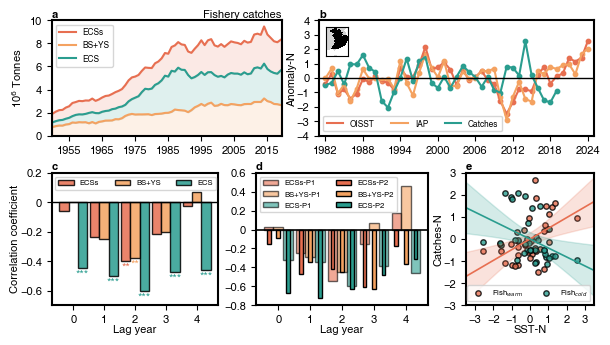

In [26]:
fig = plt.figure(figsize=(7, 3.7))
fig.subplots_adjust(wspace=0.35,hspace=0.3)
gs = GridSpec(2, 4, figure=fig,width_ratios=[1.3,0.2,0.85,1],height_ratios=[1,1.15])

ax00 = fig.add_subplot(gs[0, :2])
ax00.plot(np.arange(1950,2020),ALL_fish/1e6,c='#E76F51',lw=1.5,label='ECSs')
ax00.plot(np.arange(1950,2020),YS_fish/1e6,color='#F4A261',lw=1.5, label='BS+YS')
ax00.plot(np.arange(1950,2020),ECS_fish/1e6,color='#2A9D8F',lw=1.5, label='ECS')

ax00.fill_between(np.arange(1950,2020),np.zeros_like(YS_fish),YS_fish/1e6,color='#F4A261',alpha=0.15)
ax00.fill_between(np.arange(1950,2020),YS_fish/1e6,ECS_fish/1e6,color='#2A9D8F',alpha=0.15)
ax00.fill_between(np.arange(1950,2020),ECS_fish/1e6,ALL_fish/1e6,color='#E76F51',alpha=0.15)

ax00.set_xlim([1949.7,2019.3])
ax00.set_ylim([0,10])
ax00.set_xticks(np.arange(1955,2020)[::10],np.arange(1955,2020)[::10],fontsize=8)
ax00.set_yticks([0,2,4,6,8,10],[0,2,4,6,8,10],fontsize=8)
# ax00.set_xlabel('Year',fontsize=8)
ax00.set_ylabel('10$^6$ Tonnes',fontsize=8)
ax00.legend(loc='upper left',ncol=1,fontsize=6)
ax00.spines[['top','bottom','left','right']].set_linewidth(1.5)
ax00.set_title('a',fontsize=8,loc='left',fontweight='bold',pad=2)
ax00.set_title('Fishery catches',fontsize=8,loc='right',pad=2)

ax0 = fig.add_subplot(gs[0, 2:])
ax0.plot(np.arange(1982,2025),norm(ALL_notrend),color='#E76F51',lw=1.5, label='OISST')
ax0.scatter(np.arange(1982,2025),norm(ALL_notrend),color='#E76F51',s=10)
ax0.plot(np.arange(1982,2025),norm(ALL_IAP_notrend),color='#F4A261',lw=1.5, label='IAP')
ax0.scatter(np.arange(1982,2025),norm(ALL_IAP_notrend),color='#F4A261',s=10)
ax0.plot(np.arange(1950,2020)[32:],norm(ALL_fish_notrend[32:]),c='#2A9D8F',lw=1.5,label='Catches')
ax0.scatter(np.arange(1950,2020)[32:],norm(ALL_fish_notrend[32:]),c='#2A9D8F',s=10)

# ax0.plot(np.arange(1997,2025),norm(ALL_CHL_notrend),c='green',lw=2.5,label='chl-a')

ax0.plot(np.arange(1981,2026),np.zeros(45),'k',lw=1)
ax0.set_xlim([1981,2025])
ax0.set_ylim([-4,4])
ax0.set_xticks(np.arange(1982,2025)[::6],np.arange(1982,2025)[::6],fontsize=8)
ax0.set_yticks([-4,-3,-2,-1,0,1,2,3,4],['−4','−3','−2','−1','0','1','2','3','4'],fontsize=8)
# ax0.set_xlabel('Year',fontsize=8)
ax0.set_ylabel('Anomaly-N',fontsize=8,labelpad=0)
ax0.legend(loc='lower left',ncol=3,fontsize=6)
ax0.spines[['top','bottom','left','right']].set_linewidth(1.5)
ax0.set_title('b',fontsize=8,loc='left',fontweight='bold',pad=2)
# ax0.set_title('YS and ECS',fontsize=15)
inset_ax1 = inset_axes(ax0, width="8%", height="25%", loc="upper left")
inset_ax1.contourf(mask_land_e[70:,40:],colors='lightgrey')
inset_ax1.contourf(mask_ALL[70:,40:],colors='k')
inset_ax1.set_xticks([])
inset_ax1.set_yticks([])

inset_ax = fig.add_subplot(gs[1, 0])#inset_axes(ax0, width="29%", height="22%", loc="lower right", bbox_to_anchor=(300,115,450,350))
bars1 = inset_ax.bar(np.array([0,1,2,3,4])-0.3,lagcorr_ALL[5:-1],width=0.3,color='#E76F51', edgecolor='black',alpha=0.85,label='ECSs')
txt1 = inset_ax.bar_label(bars1, labels=f_lagp_ALL[5:-1], label_type='edge', padding=1,fontsize=8)
for txt, bar in zip(txt1, bars1):
    txt.set_color('#E76F51')

bars2 = inset_ax.bar(np.array([0,1,2,3,4]),lagcorr_YS[5:-1],width=0.3,color='#F4A261', edgecolor='black',alpha=0.85,label='BS+YS')
txt2 = inset_ax.bar_label(bars2, labels=f_lagp_YS[5:-1], label_type='edge', padding=1,fontsize=8)
for txt, bar in zip(txt2, bars2):
    txt.set_color('#F4A261')

bars3 = inset_ax.bar(np.array([0,1,2,3,4])+0.3,lagcorr_ECS[5:-1],width=0.3,color='#2A9D8F', edgecolor='black',alpha=0.85,label='ECS')
txt3 = inset_ax.bar_label(bars3, labels=f_lagp_ECS[5:-1], label_type='edge', padding=1,fontsize=8)
for txt, bar in zip(txt3, bars3):
    txt.set_color('#2A9D8F')
inset_ax.legend(loc='upper left',ncol=3,fontsize=5.5)
inset_ax.plot([-5,5],[0,0],'k',lw=1)
# inset_ax.yaxis.tick_right()
inset_ax.set_xlim([-0.7,4.7])
inset_ax.set_ylim([-0.7,0.2])
inset_ax.set_xticks([0,1,2,3,4],[0,1,2,3,4],fontsize=8)
inset_ax.set_yticks([-0.6,-0.4,-0.2,0,0.2],['−0.6','−0.4','−0.2','0','0.2'],fontsize=8)
inset_ax.spines[['top','bottom','left','right']].set_linewidth(1.5)
inset_ax.set_ylabel('Correlation coefficient',fontsize=8,labelpad=0)
inset_ax.set_xlabel('Lag year',fontsize=8,labelpad=0)
inset_ax.set_title('c',fontsize=8,loc='left',fontweight='bold',pad=2)

ax1 = fig.add_subplot(gs[1, 3])
ax1.scatter(norm(ALL_notrend[:-7]),norm(ALL_fish_warm_notrend[34:]),s=15,c='#E76F51', edgecolor='black',label='Fish$_{warm}$',alpha=0.8)
ax1.scatter(norm(ALL_notrend[:-7]),norm(ALL_fish_cold_notrend[34:]),s=15,c='#2A9D8F', edgecolor='black',label='Fish$_{cold}$',alpha=0.8)
ax1.plot(x_warm_fit_a, y_warm_fit_a,c='#E76F51',lw=1.2)
ax1.fill_between(x_warm_fit_a, y_warm_fit_a - ci_warm_a, y_warm_fit_a + ci_warm_a,alpha=0.2,color='#E76F51')
ax1.plot(x_cold_fit_a, y_cold_fit_a,c='#2A9D8F',lw=1.2)
ax1.fill_between(x_cold_fit_a, y_cold_fit_a - ci_cold_a, y_cold_fit_a + ci_cold_a,alpha=0.2,color='#2A9D8F')
ax1.set_xlim([-3.5,3.5])
ax1.set_ylim([-3,3])
ax1.set_xticks([-3,-2,-1,0,1,2,3],['−3','−2','−1','0','1','2','3'],fontsize=8)
ax1.set_yticks([-3,-2,-1,0,1,2,3],['−3','−2','−1','0','1','2','3'],fontsize=8)
ax1.set_xlabel('SST-N',fontsize=8,labelpad=0)
ax1.set_ylabel('Catches-N',fontsize=8,labelpad=0)
ax1.legend(loc='lower right',ncol=2,fontsize=5.5)
ax1.spines[['top','bottom','left','right']].set_linewidth(1.5)
ax1.set_title('e',fontsize=8,loc='left',fontweight='bold',pad=2)

ax4 = fig.add_subplot(gs[1, 1:3])

bars00 = ax4.bar(np.array([0,1,2,3,4])-0.3,(corr_period(ALL_fish_notrend,YS_notrend,0, 19)[0])[5:-1],width=0.3,color='#E76F51', edgecolor='black',alpha=0.6,label='ECSs-P1')
bars11 = ax4.bar(np.array([0,1,2,3,4]),(corr_period(YS_fish_notrend,YS_notrend,0, 19)[0])[5:-1],width=0.3,color='#F4A261', edgecolor='black',alpha=0.6,label='BS+YS-P1')
bars22 = ax4.bar(np.array([0,1,2,3,4])+0.3,(corr_period(ECS_fish_notrend,ECS_notrend,0, 19)[0])[5:-1],width=0.3,color='#2A9D8F', edgecolor='black',alpha=0.6,label='ECS-P1')

bars000 = ax4.bar(np.array([0,1,2,3,4])-0.3,(corr_period(ALL_fish_notrend,YS_notrend,19, 0)[0])[5:-1],width=0.12,color='#E76F51', edgecolor='black',alpha=1,label='ECSs-P2')
bars111 = ax4.bar(np.array([0,1,2,3,4]),(corr_period(YS_fish_notrend,YS_notrend,19, 0)[0])[5:-1],width=0.12,color='#F4A261', edgecolor='black',alpha=1,label='BS+YS-P2')
bars222 = ax4.bar(np.array([0,1,2,3,4])+0.3,(corr_period(ECS_fish_notrend,ECS_notrend,19, 0)[0])[5:-1],width=0.12,color='#2A9D8F', edgecolor='black',alpha=1,label='ECS-P2')

ax4.legend(loc='upper left',ncol=2,fontsize=5.5)
ax4.plot([-6,6],[0,0],'k',lw=1.2)
ax4.set_xlim([-0.7,4.7])
ax4.set_ylim([-0.8,0.6])
ax4.set_xticks([0,1,2,3,4],[0,1,2,3,4],fontsize=8)
ax4.set_yticks([-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6],['−0.8','−0.6','−0.4','−0.2','0','0.2','0.4','0.6'],fontsize=8)
ax4.spines[['top','bottom','left','right']].set_linewidth(1.5)
# ax4.set_ylabel('Correlation coefficient',fontsize=8,labelpad=0)
ax4.set_xlabel('Lag year',fontsize=8,labelpad=0)
ax4.set_title('d',fontsize=8,loc='left',fontweight='bold',pad=2)

# ax = fig.add_subplot(gs[:, 2], projection=ccrs.PlateCarree())
# ax.set_extent([117,131.2,19.8,41.5], crs=ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder=2)
# ax.add_feature(cfeature.COASTLINE.with_scale('10m'),lw=1,zorder=4)

# cs = ax.contourf(SST.lon.data,SST.lat.data,pearsonr(CHL,SST[15:],axis=0)[0],levels=np.linspace(-0.8,0.8,13),cmap='Spectral_r')
# cc = ax.contour(SST.lon.data,SST.lat.data,np.mean(CHL,axis=0),levels=[1,2],colors='dimgrey',linewidths=2)
# ax.clabel(cc,fontsize=13)
# gl =ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
# gl.left_labels = True
# gl.bottom_labels = True
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 13}
# gl.ylabel_style = {'size': 13}
# ax.set_xticks([118, 122, 126, 130])
# ax.set_xticklabels([' ',' ',' ',' '])
# ax.set_yticks([20, 25, 30, 35, 40])
# ax.set_yticklabels([' ',' ',' ',' ',' '])
# gl.xlocator = ticker.FixedLocator([118, 122, 126, 130])
# gl.ylocator = ticker.FixedLocator([20,25, 30,35,40])
# ax.tick_params(axis='both', length=4, width=1.2)
# ax.spines['geo'].set_linewidth(2)
# ax.set_title('(d)',fontsize=15,loc='left')
# ax.set_title('CHL [mg/m$^3$]',fontsize=15)
# cax = add_right_cax_big(ax,ax, pad=0.012, width=0.01)
# cb =  fig.colorbar(cs,cax=cax,drawedges=True)
# cb.set_ticks([-0.8,-0.4,0,0.4,0.8])
# cb.set_ticklabels([-0.8,-0.4,0,0.4,0.8],fontsize=13)
# cb.outline.set_edgecolor('black')
# cb.outline.set_linewidth(2)
# cb.dividers.set_linewidth(1)

fig_format = 'pdf'
fig.savefig('./fig/Fig6.' + fig_format, format=fig_format, dpi = 300, bbox_inches='tight')

In [ ]:
#264653, #2A9D8F, #E9C46A, #F4A261, #E76F51

In [19]:
mask_p_chl = pearsonr(CHL,SST[15:],axis=0)[0]>0.25
mask_n_chl = pearsonr(CHL,SST[15:],axis=0)[0]<-0.25

In [20]:
CHL_ECS_p = weight_mean(CHL*mask_ECS*mask_p_chl,dx_ES,dy_ES)
ALL_CHL_p_notrend = CHL_ECS_p - eemd(CHL_ECS_p)

CHL_ECS_n = weight_mean(CHL*mask_ECS*mask_n_chl,dx_ES,dy_ES)
ALL_CHL_n_notrend = CHL_ECS_n - eemd(CHL_ECS_n)

In [21]:
lagcorr_ALL_CHL_p, lagp_ALL_CHL_p = corr_CHL(ALL_fish_notrend,ALL_CHL_p_notrend,15)
f_lagp_ALL_CHL_p = get_flag(lagp_ALL_CHL_p)

lagcorr_ALL_CHL_n, lagp_ALL_CHL_n = corr_CHL(ALL_fish_notrend,ALL_CHL_n_notrend,15)
f_lagp_ALL_CHL_n = get_flag(lagp_ALL_CHL_n)

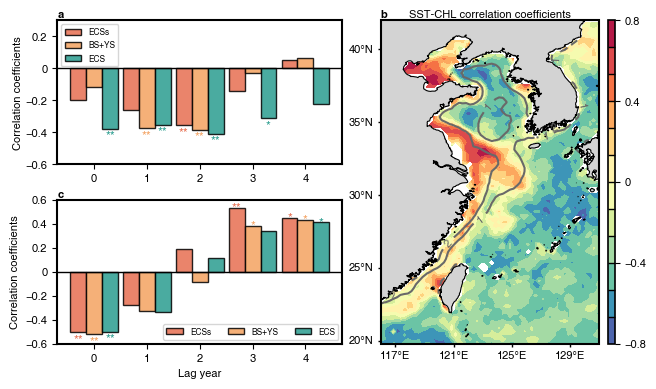

In [28]:
fig = plt.figure(figsize=(7, 4.2))
fig.subplots_adjust(hspace=0.25,wspace=0.15)
gs = GridSpec(2, 2, figure=fig,height_ratios=[1,1],width_ratios=[1.3,1])

inset_ax = fig.add_subplot(gs[0, 0])#inset_axes(ax0, width="29%", height="22%", loc="lower right", bbox_to_anchor=(300,115,450,350))
bars1 = inset_ax.bar(np.array([0,1,2,3,4])-0.3,lagcorr_ALL_IAP[5:-1],width=0.3,color='#E76F51', edgecolor='black',alpha=0.85,label='ECSs')
txt1 = inset_ax.bar_label(bars1, labels=f_lagp_ALL_IAP[5:-1], label_type='edge', padding=1,fontsize=9)
for txt, bar in zip(txt1, bars1):
    txt.set_color('#E76F51')

bars2 = inset_ax.bar(np.array([0,1,2,3,4]),lagcorr_YS_IAP[5:-1],width=0.3,color='#F4A261', edgecolor='black',alpha=0.85,label='BS+YS')
txt2 = inset_ax.bar_label(bars2, labels=f_lagp_YS_IAP[5:-1], label_type='edge', padding=1,fontsize=9)
for txt, bar in zip(txt2, bars2):
    txt.set_color('#F4A261')

bars3 = inset_ax.bar(np.array([0,1,2,3,4])+0.3,lagcorr_ECS_IAP[5:-1],width=0.3,color='#2A9D8F', edgecolor='black',alpha=0.85,label='ECS')
txt3 = inset_ax.bar_label(bars3, labels=f_lagp_ECS_IAP[5:-1], label_type='edge', padding=1,fontsize=9)
for txt, bar in zip(txt3, bars3):
    txt.set_color('#2A9D8F')
inset_ax.legend(loc='upper left',ncol=1,fontsize=6)
inset_ax.plot([-6,6],[0,0],'k',lw=1)
# inset_ax.yaxis.tick_right()
inset_ax.set_xlim([-0.7,4.7])
inset_ax.set_ylim([-0.6,0.3])
inset_ax.set_xticks([0,1,2,3,4],[0,1,2,3,4],fontsize=8)
inset_ax.set_yticks([-0.6,-0.4,-0.2,0,0.2],['−0.6','−0.4','−0.2','0','0.2'],fontsize=8)
inset_ax.spines[['top','bottom','left','right']].set_linewidth(1.5)
inset_ax.set_ylabel('Correlation coefficients',fontsize=8,labelpad=2)
# inset_ax.set_xlabel('Lag Year',fontsize=8)
inset_ax.set_title('a',fontsize=8,loc='left',fontweight='bold',pad=2)

# ax4 = fig.add_subplot(gs[1, 1])
# bars11 = ax4.bar(np.array([-3,-2,-1,0,1,2,3])-0.2,(corr_period(YS_fish_notrend,YS_notrend,0, 19)[0])[2:-2],width=0.4,color='#E76F51', edgecolor='black',alpha=0.6,label='BS+YS-P1')
# # txt11 = ax4.bar_label(bars11, labels=(corr_period(YS_fish_notrend,YS_notrend,0, 19)[1])[2:-2], label_type='edge', padding=1,fontsize=8)
# # for txt, bar in zip(txt11, bars11):
# #     txt.set_color('#E76F51')

# bars111 = ax4.bar(np.array([-3,-2,-1,0,1,2,3])-0.2,(corr_period(YS_fish_notrend,YS_notrend,19, 0)[0])[2:-2],width=0.15,color='#E76F51', edgecolor='black',alpha=1,label='BS+YS-P2')

# bars22 = ax4.bar(np.array([-3,-2,-1,0,1,2,3])+0.2,(corr_period(ECS_fish_notrend,ECS_notrend,0, 19)[0])[2:-2],width=0.4,color='#2A9D8F', edgecolor='black',alpha=0.6,label='ECS-P1')
# # txt22 = ax4.bar_label(bars22, labels=(corr_period(ECS_fish_notrend,ECS_notrend,0, 19)[1])[2:-2], label_type='edge', padding=1,fontsize=8)
# # for txt, bar in zip(txt22, bars22):
# #     txt.set_color('#2A9D8F')
# bars222 = ax4.bar(np.array([-3,-2,-1,0,1,2,3])+0.2,(corr_period(ECS_fish_notrend,ECS_notrend,19, 0)[0])[2:-2],width=0.15,color='#2A9D8F', edgecolor='black',alpha=1,label='ECS-P2')

# ax4.legend(loc='upper right',ncol=2,fontsize=11)
# ax4.plot([-6,6],[0,0],'k',lw=1.2)
# ax4.set_xlim([-3.7,3.7])
# ax4.set_ylim([-0.8,0.45])
# ax4.set_xticks([-3,-2,-1,0,1,2,3],[-3,-2,-1,0,1,2,3],fontsize=13)
# ax4.set_yticks([-0.8,-0.6,-0.4,-0.2,0,0.2,0.4],[-0.8,-0.6,-0.4,-0.2,0,0.2,0.4],fontsize=13)
# ax4.spines[['top','bottom','left','right']].set_linewidth(2)
# ax4.set_ylabel('Correlation Coefficient',fontsize=8)
# ax4.set_xlabel('Lag Year',fontsize=8)
# ax4.set_title('(d)',fontsize=15,loc='left')

ax = fig.add_subplot(gs[:, 1], projection=ccrs.PlateCarree())
ax.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder=2)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'),lw=0.8,zorder=4)

cs = ax.contourf(SST.lon.data,SST.lat.data,pearsonr(CHL,SST[15:],axis=0)[0],levels=np.linspace(-0.8,0.8,13),cmap='Spectral_r')
cc = ax.contour(SST.lon.data,SST.lat.data,np.mean(CHL,axis=0),levels=[1,2],colors='dimgrey',linewidths=1.5)
ax.clabel(cc,fontsize=8)
gl =ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl.left_labels = True
gl.bottom_labels = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}
ax.set_xticks([117, 121, 125, 129])
ax.set_xticklabels([' ',' ',' ',' '])
ax.set_yticks([20, 25, 30, 35, 40])
ax.set_yticklabels([' ',' ',' ',' ',' '])
gl.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax.tick_params(axis='both', length=2, width=1)
ax.spines['geo'].set_linewidth(1.5)
ax.set_title('b',fontsize=8,loc='left',fontweight='bold',pad=2)
ax.set_title('SST-CHL correlation coefficients',fontsize=8,pad=2)
cax = add_right_cax_big(ax,ax, pad=0.012, width=0.01)
cb =  fig.colorbar(cs,cax=cax,drawedges=True)
cb.set_ticks([-0.8,-0.4,0,0.4,0.8])
cb.set_ticklabels(['−0.8','−0.4','0','0.4','0.8'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)

inset_ax1 = fig.add_subplot(gs[1, 0])#inset_axes(ax0, width="29%", height="22%", loc="lower right", bbox_to_anchor=(300,115,450,350))
bars11 = inset_ax1.bar(np.array([0,1,2,3,4])-0.3,lagcorr_ALL_CHL[5:-1],width=0.3,color='#E76F51', edgecolor='black',alpha=0.85,label='ECSs')
txt11 = inset_ax1.bar_label(bars11, labels=f_lagp_ALL_CHL[5:-1], label_type='edge', padding=1,fontsize=9)
for txt, bar in zip(txt11, bars11):
    txt.set_color('#E76F51')
    if bar.get_height() > 0:
        txt.set_y(bar.get_height() - 5)

bars22 = inset_ax1.bar(np.array([0,1,2,3,4]),lagcorr_YS_CHL[5:-1],width=0.3,color='#F4A261', edgecolor='black',alpha=0.85,label='BS+YS')
txt22 = inset_ax1.bar_label(bars22, labels=f_lagp_YS_CHL[5:-1], label_type='edge', padding=1,fontsize=9)
for txt, bar in zip(txt22, bars22):
    txt.set_color('#F4A261')
    if bar.get_height() > 0:
        txt.set_y(bar.get_height() - 5)

bars33 = inset_ax1.bar(np.array([0,1,2,3,4])+0.3,lagcorr_ECS_CHL[5:-1],width=0.3,color='#2A9D8F', edgecolor='black',alpha=0.85,label='ECS')
txt33 = inset_ax1.bar_label(bars33, labels=f_lagp_ECS_CHL[5:-1], label_type='edge', padding=1,fontsize=9)
for txt, bar in zip(txt33, bars33):
    txt.set_color('#2A9D8F')
    if bar.get_height() > 0:
        txt.set_y(bar.get_height() - 5)

inset_ax1.legend(loc='lower right',ncol=3,fontsize=6)
inset_ax1.plot([-6,6],[0,0],'k',lw=1)
# inset_ax.yaxis.tick_right()
inset_ax1.set_xlim([-0.7,4.7])
inset_ax1.set_ylim([-0.6,0.6])
inset_ax1.set_xticks([0,1,2,3,4],[0,1,2,3,4],fontsize=8)
inset_ax1.set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6],['−0.6','−0.4','−0.2','0','0.2','0.4','0.6'],fontsize=8)
inset_ax1.spines[['top','bottom','left','right']].set_linewidth(1.5)
inset_ax1.set_ylabel('Correlation coefficients',fontsize=8)
inset_ax1.set_xlabel('Lag year',fontsize=8)
inset_ax1.set_title('c',fontsize=8,loc='left',fontweight='bold',pad=2)

fig_format = 'pdf'
fig.savefig('./fig/FigS8.' + fig_format, format=fig_format, dpi = 300, bbox_inches='tight')